# Statistik-Projekt HS25 – Multiple Regression & Interaktionen
## Notebook 11: Interaktionseffekte, Multikollinearität (VIF) & Panel-Fixed-Effects (Haltestellen-FE)

In diesem Notebook erweitern wir das Modell aus N10 um Interaktionseffekte und prüfen die Multikollinearität der Regressoren über den Variance Inflation Factor (VIF).
Zusätzlich schätzen wir ein Fixed-Effects-Panelmodell (Haltestellen-FE), um zeitinvariante Unterschiede zwischen Haltestellen zu kontrollieren.

**Ziel:**
- Prüfen, ob ein Interaktionsmodell (Stunde × Wochentag) die Verspätungen besser beschreibt als das Basismodell.
- Einordnen, ob dabei relevante Multikollinearität entsteht (VIF / Condition Number).
- Mit dem Panel-FE-Modell testen, ob Zeit-/Wochentagseffekte innerhalb derselben Haltestelle bestehen (Within-Interpretation).

**Hinweis zur Zielvariable:** Wir verwenden `delay_log = log1p(delay_clean)` (Frühankünfte auf 0 gekappt), damit Ausreißer weniger dominieren.

## Imports und Daten laden

In [3]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from linearmodels.panel import PanelOLS

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "../data/processed/istdata_trains_clean.parquet"
SAMPLE_SIZE = 500_000

df_pl = (
    pl.read_parquet(DATA_PATH)
    .select(["delay_arrival_s", "ANKUNFTSZEIT", "Wochentag_Name", "HALTESTELLEN_NAME"])
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_min"),
        pl.col("ANKUNFTSZEIT").dt.hour().alias("hour"),
        pl.col("ANKUNFTSZEIT").dt.date().alias("date"),
    ])
    .drop_nulls()
)

# Stichprobe ziehen (RAM sparen)
if SAMPLE_SIZE is not None and SAMPLE_SIZE < df_pl.height:
    df_pl = df_pl.sample(n=SAMPLE_SIZE, shuffle=True, seed=42)

print(f"Anzahl Beobachtungen in N11: {df_pl.height:,}")

# In pandas für statsmodels / linearmodels
df = df_pl.to_pandas()

df["delay_clean"] = df["delay_min"].clip(lower=0)
df["delay_log"] = np.log1p(df["delay_clean"])


Anzahl Beobachtungen in N11: 500,000


## Basis Modell

In [4]:
model_base = smf.ols(
    "delay_log ~ hour + I(hour**2) + C(Wochentag_Name)",
    data=df
).fit()

print("=== Basis-Modell (Stichprobe) ===")
print(model_base.summary())

=== Basis-Modell (Stichprobe) ===
                            OLS Regression Results                            
Dep. Variable:              delay_log   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     481.5
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:48:35   Log-Likelihood:            -3.8821e+05
No. Observations:              500000   AIC:                         7.764e+05
Df Residuals:                  499991   BIC:                         7.765e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## Modell 2: Modell mit Interaktion (hour × Wochentag)

In [5]:
model_interact = smf.ols(
    "delay_log ~ hour * C(Wochentag_Name) + I(hour**2)",
    data=df
).fit()

print("\n=== Interaktions-Modell: hour × Wochentag (Stichprobe) ===")
print(model_interact.summary())



=== Interaktions-Modell: hour × Wochentag (Stichprobe) ===
                            OLS Regression Results                            
Dep. Variable:              delay_log   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     289.2
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:48:45   Log-Likelihood:            -3.8811e+05
No. Observations:              500000   AIC:                         7.763e+05
Df Residuals:                  499985   BIC:                         7.764e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

## Modellvergleich: AIC & BIC

In [6]:
print("\n=== Modellvergleich (AIC / BIC) ===")
print(f"AIC Basis-Modell:         {model_base.aic:,.0f}")
print(f"AIC Interaktions-Modell:  {model_interact.aic:,.0f}")
print(f"BIC Basis-Modell:         {model_base.bic:,.0f}")
print(f"BIC Interaktions-Modell:  {model_interact.bic:,.0f}")


=== Modellvergleich (AIC / BIC) ===
AIC Basis-Modell:         776,440
AIC Interaktions-Modell:  776,257
BIC Basis-Modell:         776,540
BIC Interaktions-Modell:  776,424


## Multikollinearität prüfen: VIF für das Interaktions-Modell

Vollständige Designmatrix: 500,000 Zeilen, 15 Spalten
VIF-Berechnung auf Stichprobe mit 50,000 Zeilen.


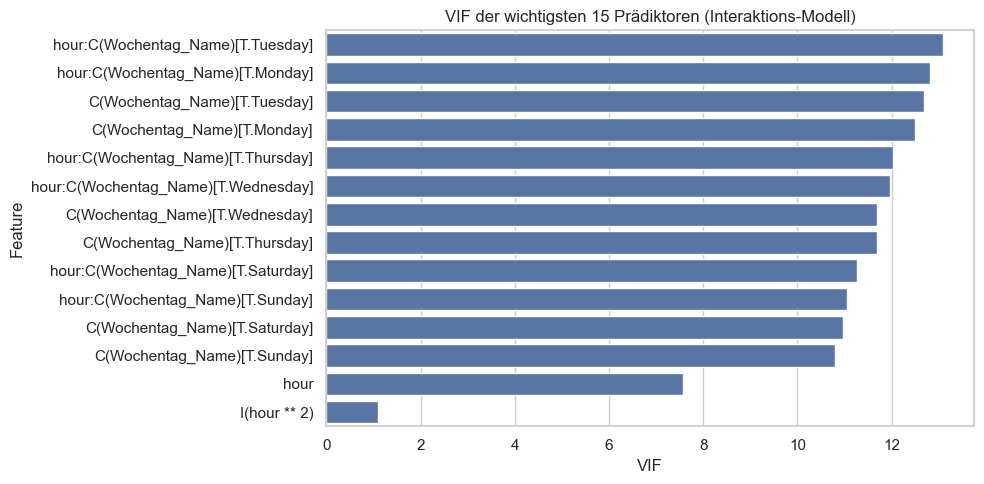

In [7]:
X_full = model_interact.model.exog
feature_names = model_interact.model.exog_names

print(f"Vollständige Designmatrix: {X_full.shape[0]:,} Zeilen, {X_full.shape[1]} Spalten")

# Für die VIF-Berechnung zusätzlich auf max. 50'000 Zeilen herunter-sampeln
max_rows_vif = 50_000
if X_full.shape[0] > max_rows_vif:
    step = int(np.ceil(X_full.shape[0] / max_rows_vif))
    X = X_full[::step, :]
    print(f"VIF-Berechnung auf Stichprobe mit {X.shape[0]:,} Zeilen.")
else:
    X = X_full

vif_values = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X, i)
    vif_values.append(vif)

vif_df = pd.DataFrame({
    "feature": feature_names,
    "VIF": vif_values
})

# Intercept rausfiltern, weil VIF dort nicht interpretierbar ist
vif_df = vif_df[vif_df["feature"] != "Intercept"].reset_index(drop=True)

vif_df.sort_values("VIF", ascending=False).head(15)

top_n = 15
vif_top = vif_df.sort_values("VIF", ascending=False).head(top_n)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=vif_top,
    x="VIF",
    y="feature",
    orient="h"
)
plt.title(f"VIF der wichtigsten {top_n} Prädiktoren (Interaktions-Modell)")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Panelmodell (Fixed Effects)

Unsere Daten enthalten wiederholte Beobachtungen derselben Haltestellen über die Zeit (September 2025) – das ist eine typische Panel-Struktur.

**Motivation:** Haltestellen unterscheiden sich strukturell (z.B. Infrastruktur, Lage, Umsteigeknoten). Diese Unterschiede sind häufig zeitlich konstant und können in einem gepoolten OLS die Schätzungen verzerren.

Mit einem Fixed-Effects Panelmodell (EntityEffects) kontrollieren wir alle zeitinvarianten Eigenschaften pro Haltestelle. Die Koeffizienten für `hour` und `Wochentag` sind dann als Within-Haltestelle-Effekte interpretierbar (also “innerhalb derselben Haltestelle über die Zeit”).

Da wir pro Tag mehrere Stundenbeobachtungen haben, definieren wir den Zeitindex als **Datum + Stunde** (ein `datetime` pro Haltestelle und Stunde). Damit ist der Zeitindex pro Entity eindeutig und panel-tauglich.

In [9]:
entity_col = "HALTESTELLEN_NAME"

# Aggregation: Haltestelle × Datum × Stunde × Wochentag
panel_df = (
    df
    .groupby([entity_col, "date", "hour", "Wochentag_Name"], as_index=False)
    .agg(
        mean_delay_log=("delay_log", "mean"),
        n_obs=("delay_log", "size")
    )
)

print("\nPanel-DataFrame Shape:", panel_df.shape)
display(panel_df.head())

panel_df["time"] = pd.to_datetime(panel_df["date"]) + pd.to_timedelta(panel_df["hour"], unit="h")
panel_df = panel_df.set_index([entity_col, "time"]).sort_index()


# Fixed Effects Modell
fe_model = PanelOLS.from_formula(
    "mean_delay_log ~ 1 + hour + I(hour**2) + C(Wochentag_Name) + EntityEffects",
    data=panel_df
)

fe_res = fe_model.fit(cov_type="clustered", cluster_entity=True)

print("\n=== Fixed-Effects Panelmodell (Haltestellen-FE) ===")
print(fe_res.summary)


Panel-DataFrame Shape: (360483, 6)


,HALTESTELLEN_NAME,date,hour,Wochentag_Name,mean_delay_log,n_obs
0,Aadorf,2025-01-09,0,Monday,0.032790,1
1,Aadorf,2025-01-09,8,Monday,0.578484,1
2,Aadorf,2025-01-09,12,Monday,0.000000,2
3,Aadorf,2025-01-09,13,Monday,0.348307,1
4,Aadorf,2025-01-09,17,Monday,0.416515,1



=== Fixed-Effects Panelmodell (Haltestellen-FE) ===
                          PanelOLS Estimation Summary                           
Dep. Variable:         mean_delay_log   R-squared:                        0.0092
Estimator:                   PanelOLS   R-squared (Between):             -0.0050
No. Observations:              360483   R-squared (Within):               0.0092
Date:                Mon, Jan 05 2026   R-squared (Overall):              0.0076
Time:                        18:49:35   Log-likelihood                -2.193e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      415.38
Entities:                        1726   P-value                           0.0000
Avg Obs:                       208.85   Distribution:                F(8,358749)
Min Obs:                       1.0000                                           
Max Obs:                       642.00   F-statistic (rob

## Pooled Vergleich auf gleicher Aggregation

Zum Vergleich schätzen wir ein **gepooltes OLS** auf exakt denselben **aggregierten Panel-Daten** (Haltestelle × Datum × Stunde × Wochentag).
So ist der Vergleich fair: **gleiche Datenbasis (Aggregation)** vs. **Fixed Effects (Haltestellen-FE)**.

**Hinweis:** Die `statsmodels`-Ausgabe nutzt hier Standardfehler *nonrobust*. Für strengere Inferenz wären cluster-robuste Standardfehler (mindestens nach Haltestelle) eine sinnvolle Erweiterung.

In [10]:
panel_df_reset = panel_df.reset_index()

pooled_agg = smf.ols(
    "mean_delay_log ~ hour + I(hour**2) + C(Wochentag_Name)",
    data=panel_df_reset
).fit()

print("\n=== Pooled OLS auf aggregierten Panel-Daten (Vergleich) ===")
print(pooled_agg.summary())


=== Pooled OLS auf aggregierten Panel-Daten (Vergleich) ===
                            OLS Regression Results                            
Dep. Variable:         mean_delay_log   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     346.0
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:49:48   Log-Likelihood:            -2.6243e+05
No. Observations:              360483   AIC:                         5.249e+05
Df Residuals:                  360474   BIC:                         5.250e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

## Interpretation

### Basismodell vs. Interaktionsmodell (OLS, Stichprobe)
- Beide Modelle erklären nur einen sehr kleinen Anteil der Varianz (**R² ≈ 0.008**).
- Das Interaktionsmodell ist gemäss Informationskriterien leicht besser (**AIC 776’440 → 776’257**, **BIC 776’540 → 776’424**), der praktische Zusatznutzen bleibt jedoch gering.

### Multikollinearität (VIF / Condition Number)
- Die Condition Number ist im Interaktionsmodell deutlich höher (≈ **1.4e3**) und die VIFs der Wochentags-Dummies und Interaktionsterme liegen typischerweise im Bereich **~10–14**.
- Dies ist bei Dummy-Kodierung in Kombination mit Interaktionen erwartbar und weist auf eine starke Überlappung der erklärenden Variablen hin.
- Konsequenz: Einzelne Interaktionsterme sind weniger stabil interpretierbar, das Modell ist jedoch nicht grundsätzlich problematisch.

### Panelmodell (Fixed Effects, Haltestellen-FE)
- Das Fixed-Effects-Modell kontrolliert alle zeitinvarianten Eigenschaften der Haltestellen. Effekte von `hour` und `Wochentag` sind somit als Within-Haltestellen-Effekte zu interpretieren.
- Der Poolability-Test ist signifikant (**p < 0.001**), was die Verwendung von Fixed Effects rechtfertigt.
- Die Erklärungskraft bleibt dennoch gering (**Within-R² ≈ 0.009**).

### FE vs. gepooltes OLS (gleiche Aggregation)
- Die Koeffizienten der Zeit- und Wochentagseffekte sind im Fixed-Effects-Modell und im gepoolten OLS auf identisch aggregierten Daten **sehr ähnlich**.
- Dies deutet darauf hin, dass die geschätzten Effekte nicht primär durch zeitinvariante Haltestellenunterschiede verzerrt sind.
- Gleichzeitig bleibt der insgesamt erklärte Varianzanteil niedrig.

## Fazit
- Interaktionen *(hour × Wochentag)* liefern gegenüber dem Basismodell nur einen marginalen Zusatznutzen.
- Das Fixed-Effects-Panelmodell ist methodisch sinnvoll, da es unbeobachtete, zeitinvariante Haltestellenunterschiede kontrolliert.
- Trotz Panel-Ansatz bleibt die lineare Erklärungskraft insgesamt niedrig: Verspätungen werden vermutlich stärker durch weitere Faktoren bestimmt (z.B. Linien- und Zugcharakteristika, Anschlusskonflikte, betriebliche Störungen oder Netz-Topologie), die in diesem Modell nicht berücksichtigt sind.

**Einschränkung:** Zeitinvariante Haltestellenmerkmale können im Fixed-Effects-Modell nicht separat geschätzt werden, da sie vollständig in den Haltestellen-Fixed-Effects aufgehen.